In [1]:
## ---- Partition Cell Set Analysis - Extended Analysis ---- 0531.00.00
## Load Analysis Parameters (Parm1)
## Loop Through Each Partition and Perform Analysis as Follows:
## Load Partition Cell Set
## Load Partition Differential Expresssion Gene Set Model
## Load Top Genes Analysis Per Cluster and Save
## Plot Dot Plot by Clusters
## Plot Partition Cell Clots Colorized by Patient
## Plot Original 15 Partition Cell Set by Colorized by Patient
## Plot Original 15 Partition Cell Set by Colorized by Partition and Labelled by Cell Type
## Perform Other Plots as Needed

In [2]:
## Create a Working Input and Output Data Directory, If Id Does Not Exist
parentdir <- '/gpfs/group/torkamani/devans/'
datdir <- paste(parentdir, 'CDC2', sep = '')
if (!file.exists(datdir)) {
    dir.create(datdir)
}
setwd(datdir)

In [3]:
## Read the parameters file
ps <- read.table(file = 'parms.txt', stringsAsFactors = FALSE, header = TRUE)

In [5]:
## Load Monocle3 and Seurat Libraries
library(monocle3)
library(Seurat)
library(dplyr)
library(magrittr)
library(ggplot2)
library(gridExtra)
library(Matrix)
library(rhdf5)
library(grid)

## Load modified version of Monocle 3 dot plot (adds as.ordered type)
source('~/code/CSC.Run2/0700.00.00.Carotid.SC.Utilities.01.r')

In [6]:
## Read the previously preprocessed downsampled cell set data object
down_stdycds <- readRDS(file = paste(ps$outdir,
                    'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

In [7]:
## Build a gene short name to gene id (Ensembl) lookup
short2geneid <- fData(down_stdycds)@rownames
names(short2geneid) <- fData(down_stdycds)@listData$gene_short_name

In [8]:
## Build a gene id (Ensembl) to gene short name lookup
geneid2short <- fData(down_stdycds)@listData$gene_short_name
names(geneid2short) <- fData(down_stdycds)@rownames

In [9]:
## Create variables for how cells sets are organized
cellgrps <- c('healthy', 'diseased', 'healthy', 'diseased', 'healthy', 'diseased')
cellpats <- c('ID Number 1', 'ID Number 1', 'ID Number 2', 'ID Number 2', 'ID Number 3', 'ID Number 3')

In [10]:
## Define and Assign Cell Types
celltypes6 <- c('1-Macrophages',
                '2-Endothelial Cells',
                '3-VSMCs',
                '4-Natural Killer Cells',
                '5-Cytotoxic T Lymphocytes',
                '6-B Lymphocytes')

In [11]:
## Declare Tom's best genes for definiting cell types
toms_markers5 <- c('NRXN1', 'CLU', 'ICAM2',
                 'CD14', 'CD68', 'AIF1',
                 'VWF', 'EDN1', 'ECSCR',
                 'MKI67', 'UBE2C', 'TOP2A',
                 'ACTA2', 'TAGLN', 'MYL9',
                 'ACKR1', 'SPARCL1', 'PECAM1',
                 'CALD1', 'MGP', 'DCN',
                 'NKG7', 'XCL1', 'CTSW',
                 'CD8A', 'TRAC', 'CD2',
                 'MS4A1', 'CD79A', 'BANK1',
                 'CD69', 'CXCR4', 'IL7R',
                 'LILRA4', 'IRF7', 'CLEC4C',
                 'MZB1', 'JCHAIN', 'TNFRSF17',
                 'LST1', 'FCGR3B', 'S100A8',
                 'TPSAB1', 'CPA3', 'MS4A2')
toms_gene_ids5 <- short2geneid[toms_markers5]


doug_markers1 <- c('AIF1', 'LYZ', 'FCER1G',  'CD68',
                'RNASE1', 'PECAM1', 'IGFBP4', 'ADIRF', 
                'SOD3', 'MYL9', 'CALD1', 'GSN',
                'TYROBP', 'NKG7', 'CTSW', 'CD69',
                'CD3D', 'CD2', 'TRBC2', 'TRAC',
                'MS4A1', 'CD79A', 'HLA-DQA1', 'CD37')
dougs_gene_ids1 <- short2geneid[doug_markers1]

In [60]:
## Loop through the partitions and plot cluster dot plots
np <- length(celltypes6)
ngenes <- 10
for (p in 1:6) {
    setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))

    ## Extract partition subset for par
    partn_cds <- readRDS('Partition.Cell.Set.rds')
    
    ## Read the top markers file
    topmarkerfile <- 'Aggregated.downsampled.QC.Cluster.TopAllMarkers.Rev1.tsv'
    topmarkers <- read.table(topmarkerfile, row.names = NULL, header = TRUE, sep = '\t', stringsAsFactors = FALSE)
    topmarkers <- topmarkers[, c(1, 3:dim(topmarkers)[2])]
    
    ## Prepare to create a dot plot (modified version of Monocle 3)
    top_specific_markers3 <- topmarkers %>%
                            filter(fraction_expressing >= 0.10) %>%
                            group_by(cell_group) %>%
                            top_n(3, pseudo_R2)
    top_specific_markers3_o <- order(top_specific_markers3$cell_group, decreasing = FALSE)
    top_specific_markers3 <- top_specific_markers3[top_specific_markers3_o, ]
    
    
    top_specific_marker_ids <- unique(top_specific_markers3 %>% pull(gene_id))
    top_specific_genes <- as.character(geneid2short[top_specific_marker_ids])
    top_specific_marker_ids <- short2geneid[top_specific_genes]
    
    ## This is a dot plot of the toms list of marker genes (5th iteration)
    g5 <- plot_genes_by_group2(partn_cds,
                    axis_order = "group_marker",
                    top_specific_marker_ids,
                    # group_cells_by = "assigned_cell_type",
                    ordering_type = "as_ordered", # "cluster_row_col" "as_ordered"
                    max.size = 8,
                    norm_method = 'size_only',
                    scale_max = 3, scale_min = -3)
    
    ## Write the updated dot plot to a file
    plotfile <- 'Partition.Cluster.Top3Genes.DOTPlot.Rev1.pdf'
    ngenes <- dim(top_specific_markers3)[1]
    pdf(plotfile, width = 2 + .12 * ngenes, height = 2 + .3 * ngenes)
    # pdf(plotfile, width = 10, height = 12)
        print(g5)
    dev.off()
}


In [70]:
## Loop through the partitions cell plots colorized by patient
np <- length(celltypes6)
ngenes <- 10
for (p in 1:6) {
    setwd(paste(datdir, '/', ps$outdir, celltypes6[p], sep = ''))

    ## Extract partition subset for par
    partn_cds <- readRDS('Partition.Cell.Set.rds')
    gp1 <- plot_cells(partn_cds, color_cells_by = "patient", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
    ## Write the cll plot
    cellcntscale <- dim(partn_cds)[2]
    plotfile <- 'ColoredbyPatient.pdf'
    pdf(plotfile, width = 3 + cellcntscale/600, height = 2 + cellcntscale/600)
        print(gp1)
    dev.off()
}

In [126]:
## Plot condition and assigned cell types for original 15 partition cell set
setwd(datdir)
down_stdycds_orig <- readRDS(file = paste(ps$outdir,
                                          'Aggregated.downsampled.QC.Doublets.Counted.rds', sep = ''))

gp2 <- plot_cells(down_stdycds_orig, color_cells_by = "condition", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)

plotfile <- 'Aggregated.downsampled.15Partitions.OriginalCellTypes.ByCondition.wLegend.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')
pdf(plotfp, width = 8, height = 6)
gp2
dev.off()

gp3 <- plot_cells(down_stdycds_orig, color_cells_by = "assigned_cell_type", group_cells_by = "partition",
                   label_cell_groups = TRUE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)

plotfile <- 'Aggregated.downsampled.15Partitions.OriginalCellTypes.ByCellType.NoLegend.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')
pdf(plotfp, width = 7, height = 6)
gp3
dev.off()


png 
  2

png 
  2

In [13]:
## Plot assigned cell types for original 15 partition cell set, with Legend and adjust size
setwd(datdir)
down_stdycds_orig <- readRDS(file = paste(ps$outdir,
                                          'Aggregated.downsampled.QC.Doublets.Counted.rds', sep = ''))

gp3l <- plot_cells(down_stdycds_orig, color_cells_by = "assigned_cell_type", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)

plotfile <- 'Aggregated.downsampled.15Partitions.OriginalCellTypes.ByCellType.WithLegend.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')
pdf(plotfp, width = 12, height = 8)
gp3l
dev.off()


png 
  2

In [101]:
help(plot_cells)

In [75]:
## EXPERIMENTION - CODE BELOW IS NOT PART OF THE ORIGINAL PIPELINE - 10/10/2020
## This code validates that the original two vsmc partiions were remixed together
## in the remixed cell set

In [ ]:
## Read the previously preprocessed downsampled cell set data object
setwd(datdir)
down_stdycds <- readRDS(file = paste(ps$outdir,
                    'Aggregated.downsampled.QC.NoDoublets.Repartitioned.rds', sep = ''))

In [ ]:
# Read the original 15 partition cell set
setwd(datdir)
down_stdycds_orig <- readRDS(file = paste(ps$outdir,
                                          'Aggregated.downsampled.QC.Doublets.Counted.rds', sep = ''))

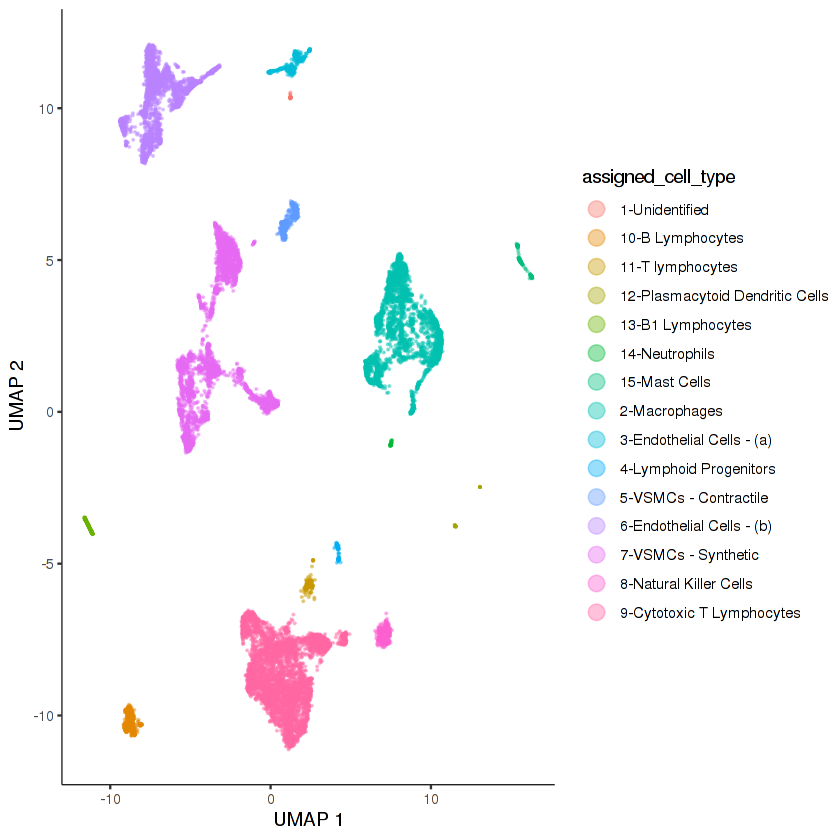

In [56]:
# Plot assigned cell types for original 15 partition cell set, with Legend and adjust size
gp3lo <- plot_cells(down_stdycds_orig, color_cells_by = "assigned_cell_type", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp3lo

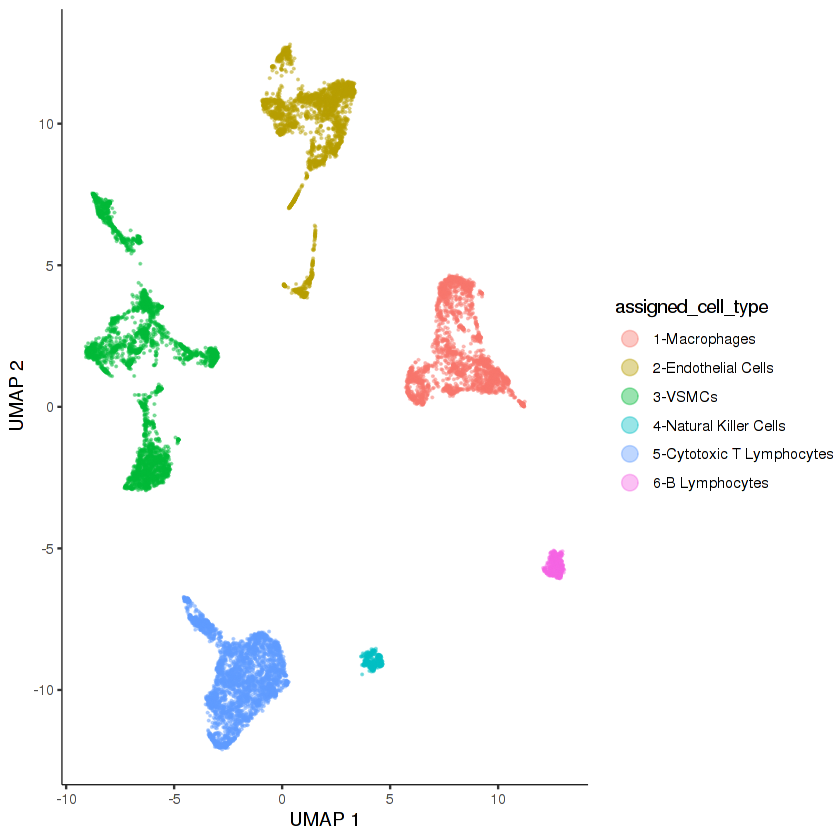

In [57]:
# Plot assigned cell types for remixed cell set, with Legend and adjust size
gp3lr <- plot_cells(down_stdycds, color_cells_by = "assigned_cell_type", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp3lr

In [42]:
## Extract Barcodes from the Original 15 Partition Cell Sets
table(colData(down_stdycds_orig)$assigned_cell_type)
bc <- colnames(down_stdycds_orig)
vsmcc_bc <- colnames(down_stdycds_orig)[colData(down_stdycds_orig)$assigned_cell_type == '5-VSMCs - Contractile']
vsmcs_bc <- colnames(down_stdycds_orig)[colData(down_stdycds_orig)$assigned_cell_type == '7-VSMCs - Synthetic']
vsmc_bc <- c(vsmcc_bc, vsmcs_bc)


                 1-Unidentified                10-B Lymphocytes 
                             24                             523 
               11-T lymphocytes 12-Plasmacytoid Dendritic Cells 
                            220                              36 
              13-B1 Lymphocytes                  14-Neutrophils 
                            198                              58 
                  15-Mast Cells                   2-Macrophages 
                            190                            3094 
      3-Endothelial Cells - (a)          4-Lymphoid Progenitors 
                            420                              87 
          5-VSMCs - Contractile       6-Endothelial Cells - (b) 
                            489                            2710 
            7-VSMCs - Synthetic          8-Natural Killer Cells 
                           3737                             370 
      9-Cytotoxic T Lymphocytes 
                           4944 

In [58]:
## Check there lengths
length(bc)
length(vsmcc_bc)
length(vsmcs_bc)
length(vsmc_bc)

[1] 17100

[1] 489

[1] 3737

[1] 4226

In [59]:
## Extract Barcodes from the Remixed Partition Cell Sets
table(colData(down_stdycds)$assigned_cell_type)
vsmcr_bc <- colnames(down_stdycds)[colData(down_stdycds)$assigned_cell_type == '3-VSMCs']


            1-Macrophages       2-Endothelial Cells                   3-VSMCs 
                     2456                      2766                      3672 
   4-Natural Killer Cells 5-Cytotoxic T Lymphocytes           6-B Lymphocytes 
                      328                      3400                       448 

In [60]:
## Check the length
length(vsmcr_bc)

[1] 3672

In [61]:
## Check some Overlaps
sum(vsmc_bc %in% vsmcr_bc)
sum(vsmc_bc %in% bc)
length(bc %in% vsmcr_bc)
sum(bc %in% vsmcr_bc)

[1] 3671

[1] 4226

[1] 17100

[1] 3672

In [62]:
## Add a Variable (vsmc) in the Original Partition Cells Set, Marking the VSMCs in the Remixed Cell Sete
colData(down_stdycds_orig)$vsmc <- 'cells excluded in vsmc remix'
colData(down_stdycds_orig)$vsmc[bc %in% vsmcr_bc] <- 'cells retained in vsmc remix'

In [63]:
## Check the size
table(colData(down_stdycds_orig)$vsmc)


cells excluded in vsmc remix cells retained in vsmc remix 
                       13428                         3672 

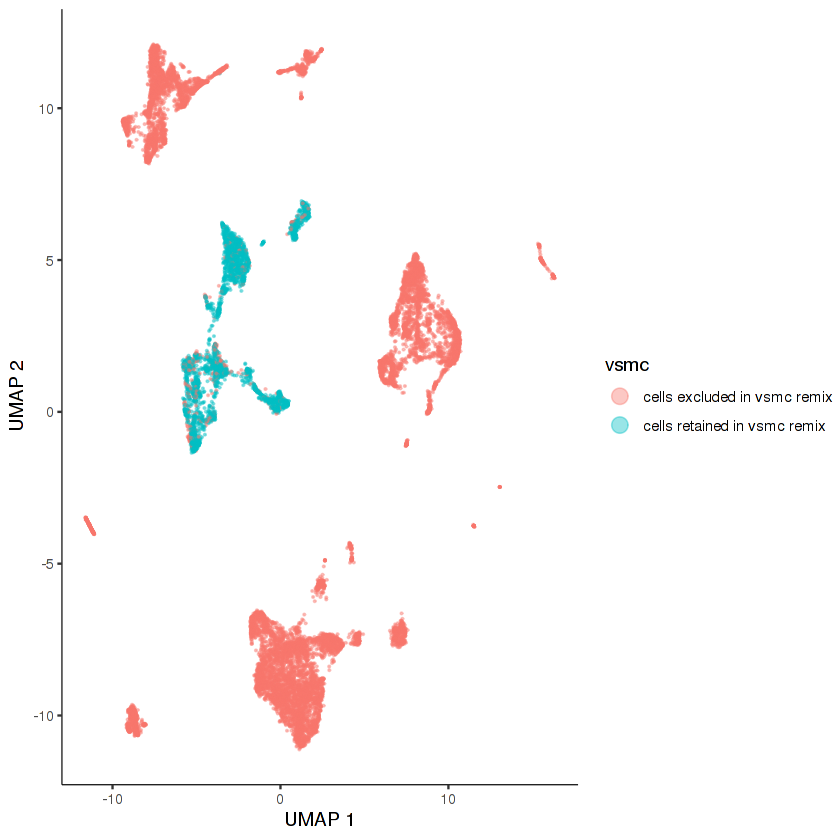

In [64]:
# Plot retained vsmc cells for original cell set, with Legend and adjust size
gp3lz <- plot_cells(down_stdycds_orig, color_cells_by = "vsmc", group_cells_by = "partition",
                   label_cell_groups = FALSE,
                   show_trajectory_graph = FALSE, reduction_method = "UMAP", cell_size = 0.1, alpha = .4)
gp3lz

In [69]:
library(ggpubr)
options(repr.plot.width=15, repr.plot.height=10)
figure <- ggarrange(gp3lo, gp3lr, gp3lz,
                    labels = c("A", "B", "C"),
                    ncol = 3, nrow = 1)

In [74]:
plotfile <- 'Aggregated.downsampled.15Partitions.VSMCCellsRetainedinRemix.WithLegend.Rev1.pdf'
plotfp <- paste(ps$outdir, plotfile, sep = '')
pdf(plotfp, width = 40, height = 10)
print(figure)
dev.off()

png 
  2